# 6.5 Unsupervised Machine Learning: Clustering

Daniel Rodelli
______________
___________________
### Table of Contents
1. Importing the Libraries and Dataset


2. Dataset preparation and observations
        2.1 Season
        2.2 Climate
        2.3 Gender
        2.4 Age
        2.5 Population Density
        
3. Cluster Analysis
        3.1 PCA
        3.2 Elbow Method
        3.3 Silouette Method
        3.4 Cluster Implementation
        3.5 Clusters Characterization
        

4. Cluster Profiling


5. Next Steps
_______________

### 1. Importing the Libraries and Dataset

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.cluster import KMeans 
import pylab as pl

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [4]:
%matplotlib inline

In [5]:
#setting the data path
path = r'C:\Users\daniel\Documents\CareerFoundry\Immersion_achievement6'

In [6]:
#importing the dataset
df = pd.read_csv(os.path.join(path,'data', 'prepared_data','df_cleaned.csv'))

In [7]:
df.head()

,Unnamed: 0,Unnamed: 0.1,State,Age_group,Gender,Date,N_cases,N_deaths,N_recoveries,day,...,year,weekday,N_cases/100k,N_deaths/100k,N_recoveries/100k,climate_flag,cases/density,deaths/density,recoveries/density,density_flag
0,0,0,Baden-Württemberg,A00-A04,F,2020-03-02,1,0,1,2,...,2020,0,0.009007,0.0,0.009007,oceanic,0.003247,0.0,0.003247,mid_density
1,1,1,Baden-Württemberg,A00-A04,F,2020-03-13,3,0,3,13,...,2020,4,0.027020,0.0,0.027020,oceanic,0.009740,0.0,0.009740,mid_density
2,2,2,Baden-Württemberg,A00-A04,F,2020-03-14,4,0,4,14,...,2020,5,0.036026,0.0,0.036026,oceanic,0.012987,0.0,0.012987,mid_density
3,3,3,Baden-Württemberg,A00-A04,F,2020-03-15,1,0,1,15,...,2020,6,0.009007,0.0,0.009007,oceanic,0.003247,0.0,0.003247,mid_density
4,4,4,Baden-Württemberg,A00-A04,F,2020-03-16,3,0,3,16,...,2020,0,0.027020,0.0,0.027020,oceanic,0.009740,0.0,0.009740,mid_density


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102850 entries, 0 to 102849
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          102850 non-null  int64  
 1   Unnamed: 0.1        102850 non-null  int64  
 2   State               102850 non-null  object 
 3   Age_group           102850 non-null  object 
 4   Gender              102850 non-null  object 
 5   Date                102850 non-null  object 
 6   N_cases             102850 non-null  int64  
 7   N_deaths            102850 non-null  int64  
 8   N_recoveries        102850 non-null  int64  
 9   day                 102850 non-null  int64  
 10  month               102850 non-null  int64  
 11  year                102850 non-null  int64  
 12  weekday             102850 non-null  int64  
 13  N_cases/100k        102850 non-null  float64
 14  N_deaths/100k       102850 non-null  float64
 15  N_recoveries/100k   102850 non-nul

In [7]:
#drop useless columns
df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)

#drop columns not to be used in the cluster analysis
df.drop(columns=['N_cases','N_deaths', 'N_recoveries', 'year', 'day', 'weekday', 
                 'cases/density','deaths/density', 'recoveries/density'], inplace=True)
df.head()

,State,Age_group,Gender,Date,month,N_cases/100k,N_deaths/100k,N_recoveries/100k,climate_flag,density_flag
0,Baden-Württemberg,A00-A04,F,2020-03-02,3,0.009007,0.0,0.009007,oceanic,mid_density
1,Baden-Württemberg,A00-A04,F,2020-03-13,3,0.027020,0.0,0.027020,oceanic,mid_density
2,Baden-Württemberg,A00-A04,F,2020-03-14,3,0.036026,0.0,0.036026,oceanic,mid_density
3,Baden-Württemberg,A00-A04,F,2020-03-15,3,0.009007,0.0,0.009007,oceanic,mid_density
4,Baden-Württemberg,A00-A04,F,2020-03-16,3,0.027020,0.0,0.027020,oceanic,mid_density


### 2. Dataset Preparation and Observations

There are 5 categorical variables in the dataset. I previous tasks I already shown a correlation between each of these and the number of cases / number of deaths per capita. The variables are:
 - Season
 - Climate
 - Gender
 - Age
 - Population Density
 
In __Cluster Analysis__ categorical variables are either to be dropped or transformed into dummy variables (0 or 1). I need to decide if each of the variables is worth to be used in the analysis.
I will look at how different the categories of each variables are between each other. If the difference is high enough, i will keep the variables, otherwise I will discard them. I might be even useful to group some categories together (such as age groups) based on their behavior.

##### 2.1 Season

In [8]:
#add a 'Season flag' as in Task 6.3
season=[]
for i in df['month']:
    if (i <=4) or (i>=11):
        season.append('cold')
    else:
        season.append('warm')
df['season']=season

#pivot table to isolate the data about the season
df_season=df.pivot_table(index=['State','season'], values=['N_cases/100k', 'N_deaths/100k'], aggfunc='sum')
df_season=df_season.reset_index()
df_season.head()

,State,season,N_cases/100k,N_deaths/100k
0,Baden-Württemberg,cold,3559.132393,85.111802
1,Baden-Württemberg,warm,1750.168850,12.050750
2,Bayern,cold,4020.111440,108.331825
3,Bayern,warm,1699.055485,11.978524
4,Berlin,cold,3799.362897,90.445426


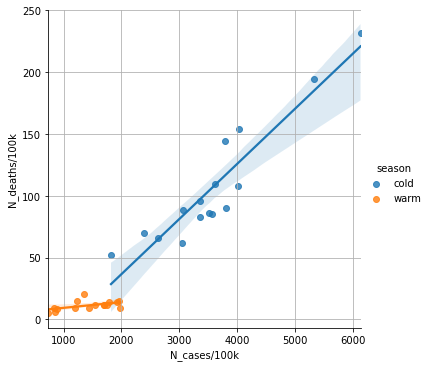

In [11]:
sns.lmplot(data=df_season, x='N_cases/100k', y='N_deaths/100k', hue='season')
plt.grid()

__The two categories have a very distinct behavior. I will keep the variable.__

###### 2.2 Climate

In [12]:
df_climate=df.pivot_table(index=['State', 'climate_flag'], values=['N_cases/100k', 'N_deaths/100k'], aggfunc='sum')
df_climate=df_climate.reset_index()
df_climate.head()

,State,climate_flag,N_cases/100k,N_deaths/100k
0,Baden-Württemberg,oceanic,5309.301243,97.162553
1,Bayern,continental,5719.166925,120.310349
2,Berlin,continental,5775.489017,99.806555
3,Brandenburg,continental,4678.217245,152.820683
4,Bremen,oceanic,5004.484437,76.455972


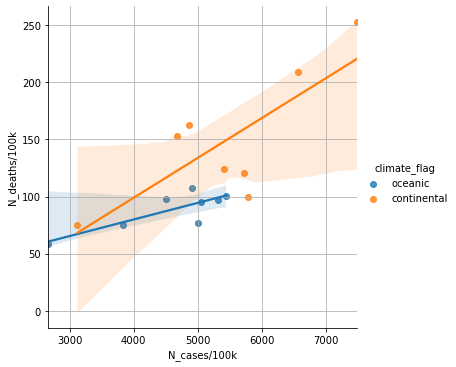

In [13]:
sns.lmplot(data=df_climate, x='N_cases/100k', y='N_deaths/100k', hue='climate_flag')
plt.grid()

__The two categories have a very distinct behavior. I will keep the variable.__

##### 2.3 Gender

In [14]:
df_gender=df.pivot_table(index=['State', 'Gender'], values=['N_cases/100k', 'N_deaths/100k'], aggfunc='sum')
df_gender=df_gender.reset_index()
df_gender.head()

,State,Gender,N_cases/100k,N_deaths/100k
0,Baden-Württemberg,F,2669.493399,45.140778
1,Baden-Württemberg,M,2621.002188,51.985748
2,Baden-Württemberg,unknown,18.805655,0.036026
3,Bayern,F,2840.074602,58.401013
4,Bayern,M,2822.624312,61.330957


In [15]:
#drop the rows with 'unknown' gender
df_gender=df_gender[~df_gender.Gender.str.contains("unknown")]

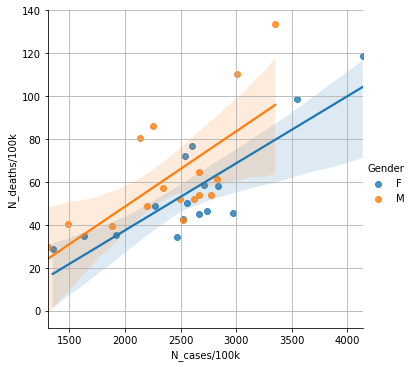

In [16]:
sns.lmplot(data=df_gender, x='N_cases/100k', y='N_deaths/100k', hue='Gender')
plt.grid()

__The categories show some differences, but not very strongly. I will keep the variable for now, and decide after the analysis if it worth to keep it or can be dropped.__

##### 2.4 Age

In [17]:
df_age=df.pivot_table(index=['State', 'Age_group'], values=['N_cases/100k', 'N_deaths/100k'], aggfunc='sum')
df_age=df_age.reset_index()
df_age.head()

,State,Age_group,N_cases/100k,N_deaths/100k
0,Baden-Württemberg,A00-A04,144.951253,0.054039
1,Baden-Württemberg,A05-A14,456.397404,0.000000
2,Baden-Württemberg,A15-A34,1694.715584,0.252183
3,Baden-Württemberg,A35-A59,2015.987869,4.746447
4,Baden-Württemberg,A60-A79,679.849659,27.992326


In [18]:
df_age=df_age[~df_age.Age_group.str.contains("unknown")]

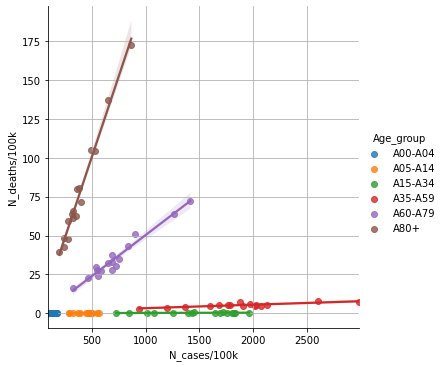

In [20]:
sns.lmplot(data=df_age, x='N_cases/100k', y='N_deaths/100k', hue='Age_group')
plt.grid()

__The categories have a very distinct behavior. I will keep the variable.__
Nonetheless, their behavior indicate that some categories can be grouped together (i.e all ages below 59 year can be grouped in a single category) )

In [9]:
#replacing categories in the primary dataframe
df.replace({'A00-A04':'under60', 'A05-A14':'under60', 'A15-A34':'under60', 'A35-A59':'under60', 
            'A60-A79':'60-79', 'A80+':'80+'}, inplace=True)
#drop 'unknown' category
#df_age=df_age[~df_age.Age_group.str.contains("unknown")]

#sum the individual entries that now are in the same age category:
df_clean=df.pivot_table(index=['State', 'Gender', 'Age_group', 'Date','climate_flag', 'season', 'density_flag', 'month'],
                 values=['N_cases/100k', 'N_deaths/100k'], aggfunc='sum')


df_clean=df_clean.reset_index()

#drop 'unknown' category from the primary dataset
df_clean=df_clean[~df_clean.Age_group.str.contains("unknown")]
df_clean=df_clean[~df_clean.Gender.str.contains("unknown")]
df_clean.head()

,State,Gender,Age_group,Date,climate_flag,season,density_flag,month,N_cases/100k,N_deaths/100k
0,Baden-Württemberg,F,60-79,2020-02-04,oceanic,cold,mid_density,2,0.009007,0.000000
1,Baden-Württemberg,F,60-79,2020-02-21,oceanic,cold,mid_density,2,0.009007,0.000000
2,Baden-Württemberg,F,60-79,2020-02-25,oceanic,cold,mid_density,2,0.009007,0.000000
3,Baden-Württemberg,F,60-79,2020-02-26,oceanic,cold,mid_density,2,0.018013,0.009007
4,Baden-Württemberg,F,60-79,2020-02-28,oceanic,cold,mid_density,2,0.018013,0.000000


Now, repeat the steps to plot a chart with the updated category values

In [22]:
df_age=df.pivot_table(index=['State', 'Age_group'], values=['N_cases/100k', 'N_deaths/100k'], aggfunc='sum')
df_age=df_age.reset_index()
df_age=df_age[~df_age.Age_group.str.contains("unknown")]
df_age.head()

,State,Age_group,N_cases/100k,N_deaths/100k
0,Baden-Württemberg,60-79,679.849659,27.992326
1,Baden-Württemberg,80+,315.472074,64.117558
2,Baden-Württemberg,under60,4312.052110,5.052669
4,Bayern,60-79,747.805415,34.679882
5,Bayern,80+,375.413341,80.387008


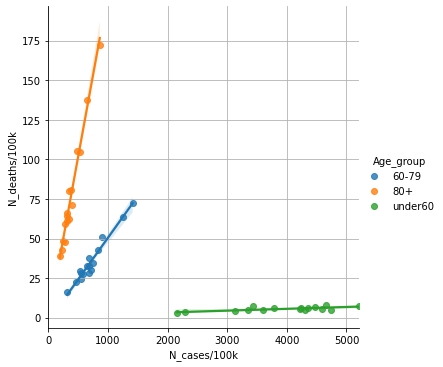

In [23]:
sns.lmplot(data=df_age, x='N_cases/100k', y='N_deaths/100k', hue='Age_group')
plt.xlim(0,)
plt.grid()

__The categories have a clear disting behavior. I will keep the variable for the analysis.__

#### 2.5 Density

In [24]:
df_density=df.pivot_table(index=['State','density_flag'], values=['N_cases/100k', 'N_deaths/100k'], aggfunc='sum')
df_density=df_density.reset_index()
df_density

,State,density_flag,N_cases/100k,N_deaths/100k
0,Baden-Württemberg,mid_density,5309.301243,97.162553
1,Bayern,low_density,5719.166925,120.310349
2,Berlin,high_density,5775.489017,99.806555
3,Brandenburg,low_density,4678.217245,152.820683
4,Bremen,high_density,5004.484437,76.455972
5,Hamburg,high_density,5053.177420,94.845931
6,Hessen,mid_density,5402.267289,123.721746
7,Mecklenburg-Vorpommern,low_density,3123.219024,75.057084
8,Niedersachsen,low_density,3829.524899,75.080394
9,Nordrhein-Westfalen,mid_density,5440.167314,100.264594


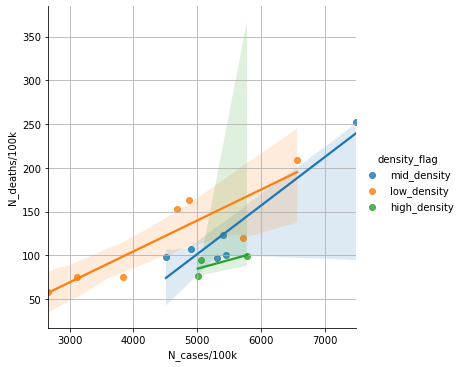

In [25]:
sns.lmplot(data=df_density, x='N_cases/100k', y='N_deaths/100k', hue='density_flag')
plt.grid()

__The categories show some differences, but much less strongly than the previous variables. I will keep the variable for the moment, and will decide later based on the results of the cluster analysis if it is worth to mantain or better to drop.__

##### 2.6 Preparing the final dataset

In [10]:
#no need for the 'Date' information, i'll sum up the values
df_clean_pv=df_clean.pivot_table(index=['State', 'Gender', 'Age_group', 'climate_flag', 'density_flag', 'season', 'month'], 
                               values=['N_cases/100k', 'N_deaths/100k'], aggfunc='sum')
df_clean_pv=df_clean_pv.reset_index()
df_clean_pv.head()

,State,Gender,Age_group,climate_flag,density_flag,season,month,N_cases/100k,N_deaths/100k
0,Baden-Württemberg,F,60-79,oceanic,mid_density,cold,1,35.566826,1.224889
1,Baden-Württemberg,F,60-79,oceanic,mid_density,cold,2,15.347144,0.468340
2,Baden-Württemberg,F,60-79,oceanic,mid_density,cold,3,45.708190,1.414027
3,Baden-Württemberg,F,60-79,oceanic,mid_density,cold,4,53.850102,1.648197
4,Baden-Württemberg,F,60-79,oceanic,mid_density,cold,11,43.186359,1.305948


In [35]:
df_clean_pv.shape

(1151, 9)

In [11]:
#creating dummy columns for the categorical variables
df_dummies=pd.get_dummies(df_clean_pv, columns=['Gender', 'Age_group','climate_flag', 'density_flag', 'season'])
df_dummies.head()

,State,month,N_cases/100k,N_deaths/100k,Gender_F,Gender_M,Age_group_60-79,Age_group_80+,Age_group_under60,climate_flag_continental,climate_flag_oceanic,density_flag_high_density,density_flag_low_density,density_flag_mid_density,season_cold,season_warm
0,Baden-Württemberg,1,35.566826,1.224889,1,0,1,0,0,0,1,0,0,1,1,0
1,Baden-Württemberg,2,15.347144,0.468340,1,0,1,0,0,0,1,0,0,1,1,0
2,Baden-Württemberg,3,45.708190,1.414027,1,0,1,0,0,0,1,0,0,1,1,0
3,Baden-Württemberg,4,53.850102,1.648197,1,0,1,0,0,0,1,0,0,1,1,0
4,Baden-Württemberg,11,43.186359,1.305948,1,0,1,0,0,0,1,0,0,1,1,0


In [13]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151 entries, 0 to 1150
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   State                      1151 non-null   object 
 1   month                      1151 non-null   int64  
 2   N_cases/100k               1151 non-null   float64
 3   N_deaths/100k              1151 non-null   float64
 4   Gender_F                   1151 non-null   uint8  
 5   Gender_M                   1151 non-null   uint8  
 6   Age_group_60-79            1151 non-null   uint8  
 7   Age_group_80+              1151 non-null   uint8  
 8   Age_group_under60          1151 non-null   uint8  
 9   climate_flag_continental   1151 non-null   uint8  
 10  climate_flag_oceanic       1151 non-null   uint8  
 11  density_flag_high_density  1151 non-null   uint8  
 12  density_flag_low_density   1151 non-null   uint8  
 13  density_flag_mid_density   1151 non-null   uint8

In [12]:
#drop unnecessary columns
df_dummies.drop(columns=['State'], inplace=True)

### 3 Cluster Analysis

In [13]:
#scaling the variables to have the same magnitude
scaler=StandardScaler()
scaled_df=scaler.fit_transform(df_dummies)

#### 3.1 PCA

In [14]:
from sklearn.decomposition import PCA

In [15]:
pca=PCA()
pca.fit(scaled_df)

PCA()

In [16]:
variance=pca.explained_variance_ratio_

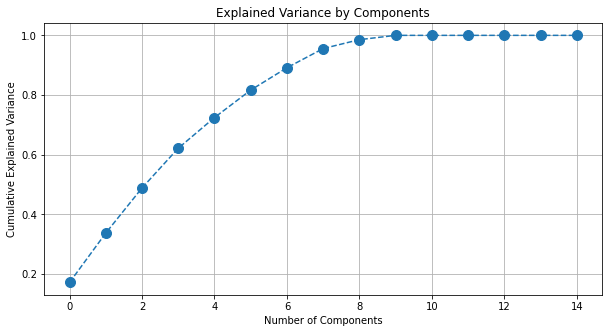

In [34]:
plt.figure(figsize=(10,5))
plt.plot(variance.cumsum(), marker ='o',markersize=10, linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()


In [17]:
pca=PCA(n_components=7)
pca.fit(scaled_df)

PCA(n_components=7)

In [18]:
scores_pca=pca.transform(scaled_df)
scores_pca

array([[-0.99737779,  1.87848349,  1.15815048, ..., -1.8884721 ,
        -1.03710311, -0.59795384],
       [-1.12019967,  1.70768584,  1.13755798, ..., -1.90497951,
        -1.02853564, -0.59180976],
       [-1.03071745,  1.82252648,  1.07866821, ..., -1.79104671,
        -1.08794744, -0.4299466 ],
       ...,
       [ 0.87889215, -1.84981127, -1.86315652, ...,  0.48244734,
         0.01528919, -0.38069472],
       [ 0.96235938, -1.6045561 , -2.2394527 , ...,  0.59167992,
        -0.04231592, -0.21258763],
       [ 0.91641935, -1.67981193, -2.25575592, ...,  0.62246619,
        -0.05835904, -0.15066039]])

#### 3.2 Elbow Method

In [37]:
wccs=[]
for i in range(1,20):
    kmeans_pca=KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_pca.fit(scores_pca)
    wccs.append(kmeans_pca.inertia_)

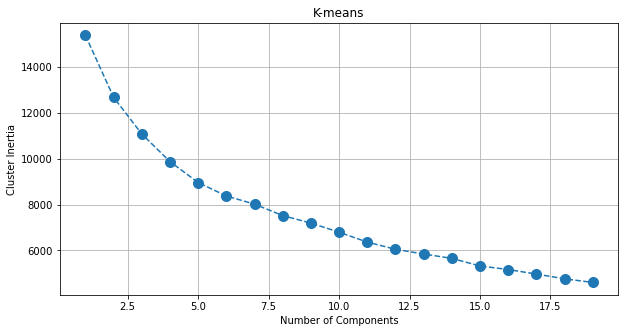

In [38]:
plt.figure(figsize=(10,5))
plt.plot(range(1,20), wccs, marker='o',markersize=10, linestyle='--')
plt.title('K-means')
plt.xlabel('Number of Components')
plt.ylabel('Cluster Inertia')
plt.grid()


The curve of __cluster inertia__ does not indicate clearly a best number for components. The elbow of the curve is somewhere between 4 and 6. I will try with the __Silouette Score__ method.

#### 3.3 Silouette Score

NameError: name 'SilhouetteVisualizer' is not defined

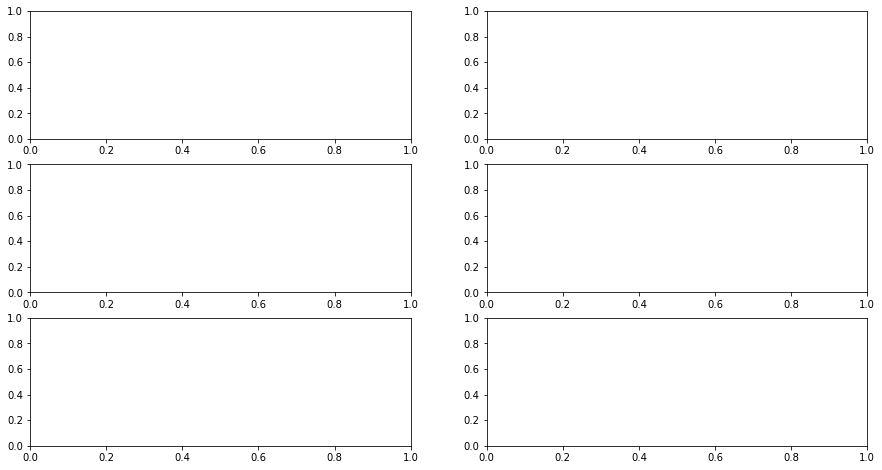

In [39]:
fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(scores_pca)
    plt.title('Clusters: ' + str(i) )

Using __6__ Clusters seems the best option.

_(all clusters are above the average silouette score, and the silouettes have about the same thickness)_ 

#### 3.4 Cluster implementation

In [19]:
kmeans_pca=KMeans(n_clusters=6,init='k-means++', random_state=17)

In [41]:
kmeans_pca

KMeans(n_clusters=6, random_state=17)

In [20]:
df = pd.read_csv(os.path.join(path,'data', 'prepared_data','df_cleaned.csv'))

In [21]:
df_clean_pv['clusters_PCA'] = kmeans_pca.fit_predict(scores_pca)

In [22]:
df_clean_pv['clusters_PCA']=df_clean_pv['clusters_PCA'].astype('category')

In [23]:
df_clean_pv['clusters_PCA'].value_counts()

4    251
0    192
2    192
3    192
5    180
1    144
Name: clusters_PCA, dtype: int64

Text(0.5, 1.0, 'Clustering')

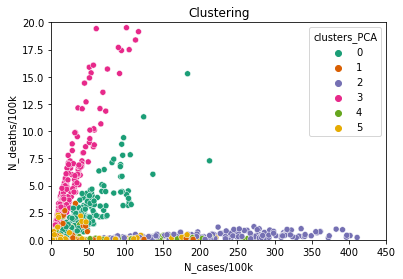

In [32]:
#plt.figure(figsize=(12,8))
sns.scatterplot(data=df_clean_pv, x='N_cases/100k', y='N_deaths/100k', hue='clusters_PCA', palette='Dark2')
plt.xlim(0,450)
plt.ylim(0, 20)
plt.title('Clustering')

<AxesSubplot:xlabel='clusters_PCA', ylabel='N_cases/100k'>

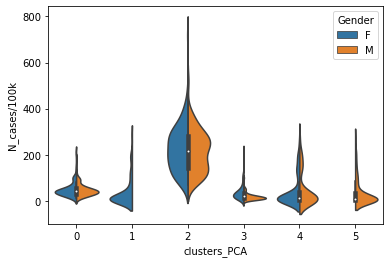

In [47]:
sns.violinplot(data=df_clean_pv, x='clusters_PCA',y='N_cases/100k', hue='Gender', split=True)

<AxesSubplot:xlabel='clusters_PCA', ylabel='N_cases/100k'>

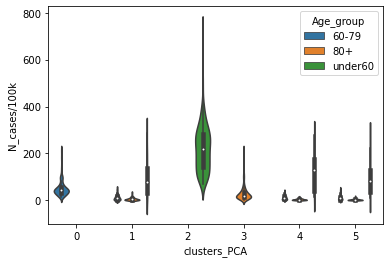

In [48]:
sns.violinplot(data=df_clean_pv, x='clusters_PCA',y='N_cases/100k', hue='Age_group')

<AxesSubplot:xlabel='clusters_PCA', ylabel='N_cases/100k'>

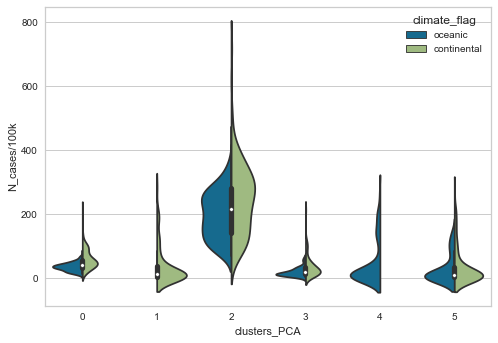

In [130]:
sns.violinplot(data=df_clean_pv, x='clusters_PCA',y='N_cases/100k', hue='climate_flag', split=True)

<AxesSubplot:xlabel='clusters_PCA', ylabel='N_cases/100k'>

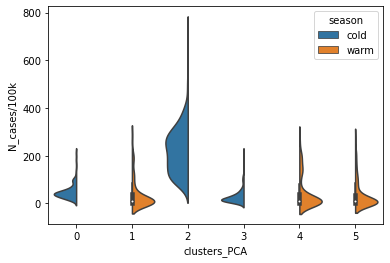

In [49]:
sns.violinplot(data=df_clean_pv, x='clusters_PCA',y='N_cases/100k', hue='season', split=True)

<AxesSubplot:xlabel='clusters_PCA', ylabel='N_cases/100k'>

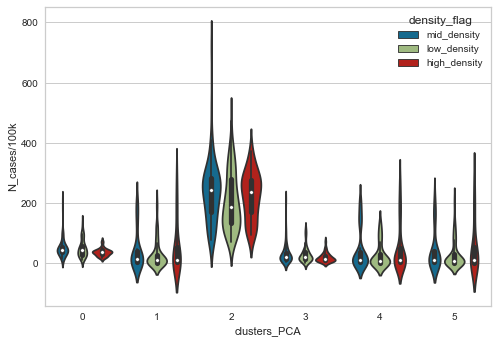

In [132]:
sns.violinplot(data=df_clean_pv, x='clusters_PCA',y='N_cases/100k', hue='density_flag')

In [50]:
#summary Clusters Statistics
cluster_stats=df_clean_pv.groupby('clusters_PCA').describe()
cluster_stats.T

clusters_PCA                  0           1           2           3  \
month         count  192.000000  144.000000  192.000000  192.000000   
              mean     5.500000    7.500000    5.500000    5.500000   
              std      4.360700    1.713786    4.360700    4.360700   
              min      1.000000    5.000000    1.000000    1.000000   
              25%      2.000000    6.000000    2.000000    2.000000   
              50%      3.500000    7.500000    3.500000    3.500000   
              75%     11.000000    9.000000   11.000000   11.000000   
              max     12.000000   10.000000   12.000000   12.000000   
N_cases/100k  count  192.000000  144.000000  192.000000  192.000000   
              mean    48.500841   36.422590  221.257774   28.130280   
              std     28.143653   56.996820   96.291258   26.457135   
              min     12.401769    0.237054   70.587184    2.920084   
              25%     31.743179    3.051129  141.804440   11.800580   
              50%     42.498590   11.406446  217.618727   19.813890   
              75%     55.921956   38.207677  281.585995   35.107937   
              max    212.401413  285.964748  717.560349  213.485974   
N_deaths/100k count  192.000000  144.000000  192.000000  192.000000   
              mean     2.656023    0.282271    0.373860    5.933019   
              std      2.048883    0.529895    0.271799    5.226479   
              min      0.206124    0.000000    0.000000    0.584017   
              25%      1.321150    0.024649    0.185542    2.590750   
              50%      2.125351    0.080664    0.307033    4.519115   
              75%      3.279187    0.262847    0.497438    6.901620   
              max     15.282450    3.352279    1.478947   37.343407   

clusters_PCA                  4           5  
month         count  251.000000  180.000000  
              mean     7.501992    7.500000  
              std      1.714350    1.712589  
              min      5.000000    5.000000  
              25%      6.000000    6.000000  
              50%      8.000000    7.500000  
              75%      9.000000    9.000000  
              max     10.000000   10.000000  
N_cases/100k  count  251.000000  180.000000  
              mean    44.839647   34.712364  
              std     66.981567   55.143002  
              min      0.269909    0.079018  
              25%      3.263781    2.199951  
              50%     10.961995    8.377017  
              75%     38.682590   36.231509  
              max    279.064297  274.665892  
N_deaths/100k count  251.000000  180.000000  
              mean     0.319959    0.336237  
              std      0.379490    0.500069  
              min      0.000000    0.000000  
              25%      0.068708    0.062375  
              50%      0.153111    0.137572  
              75%      0.441092    0.405686  
              max      2.134166    3.746665

#### 3.5 Clusters Characterization

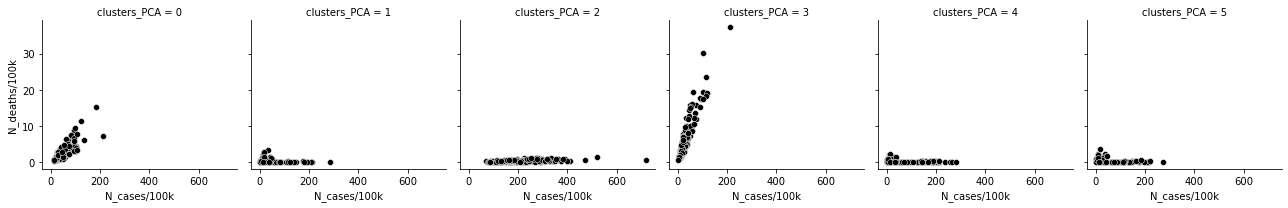

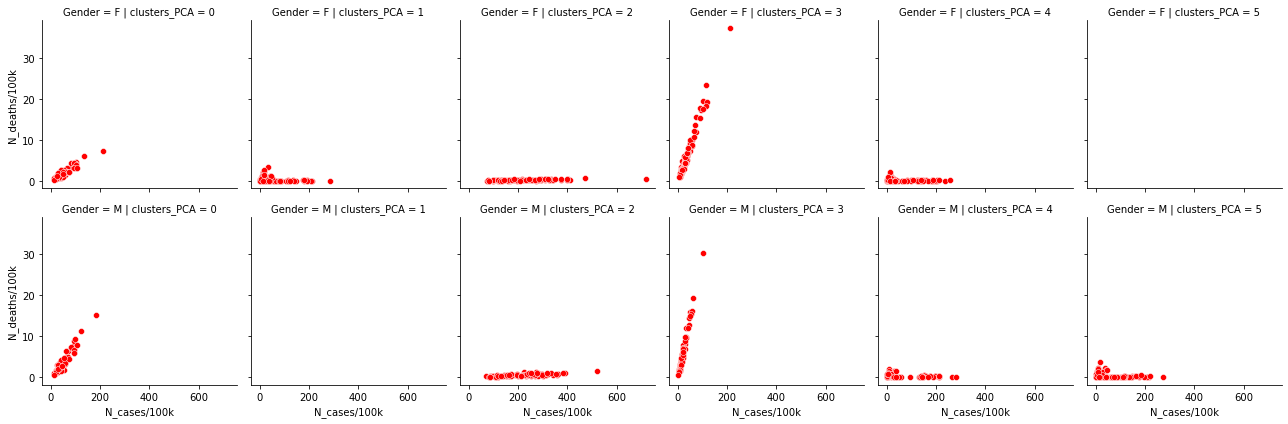

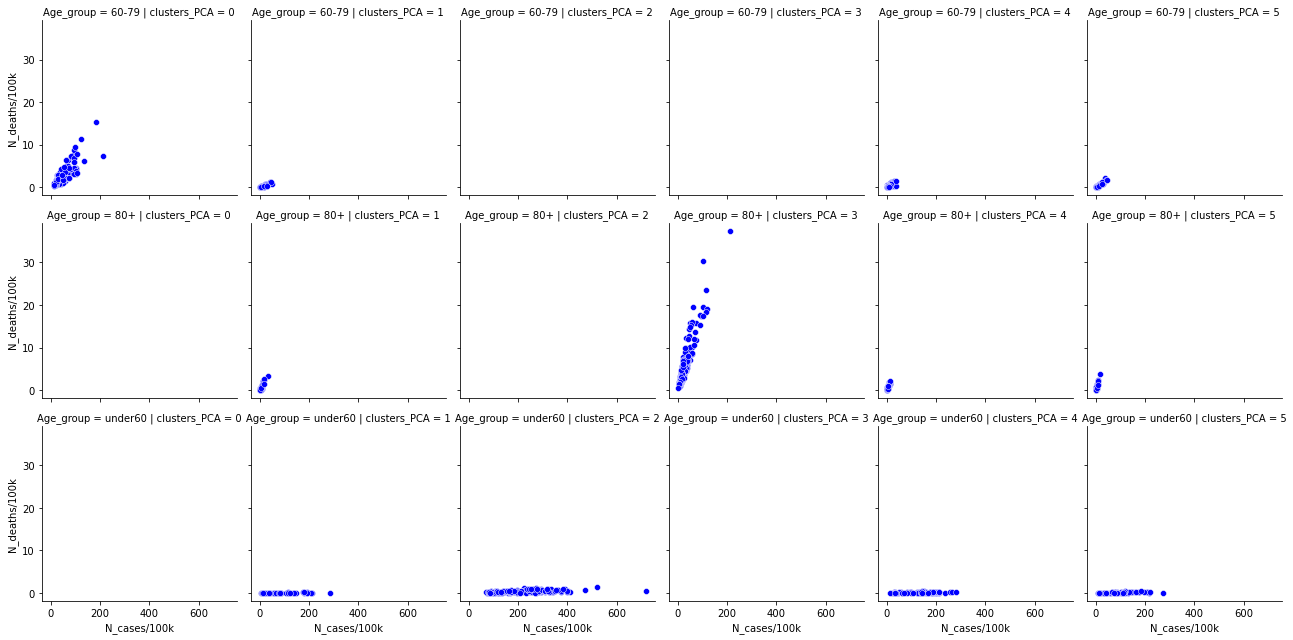

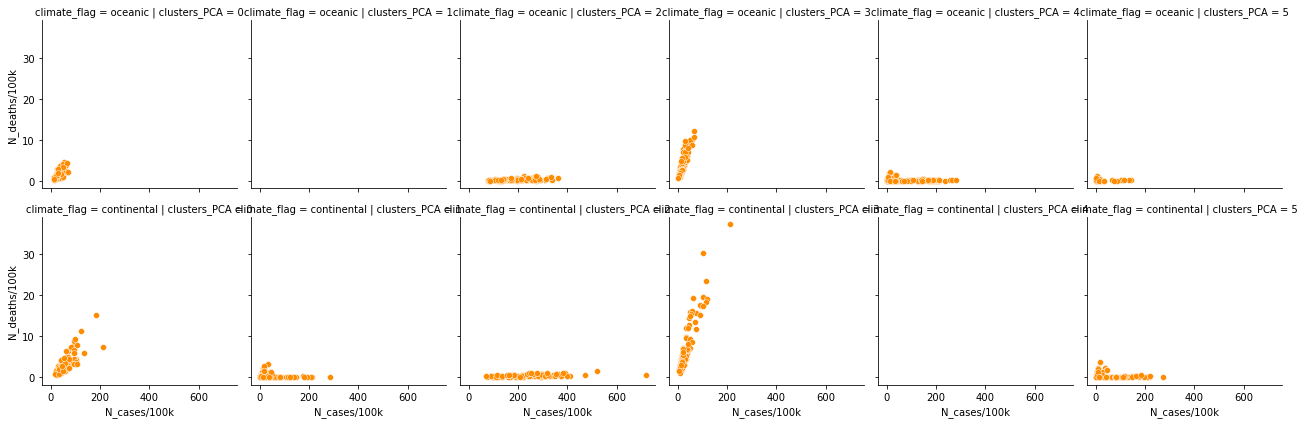

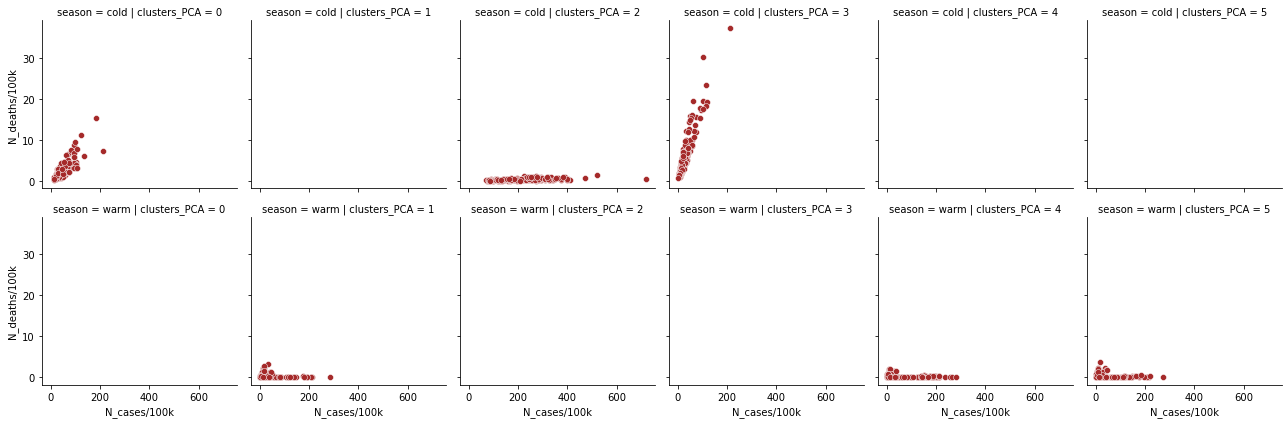

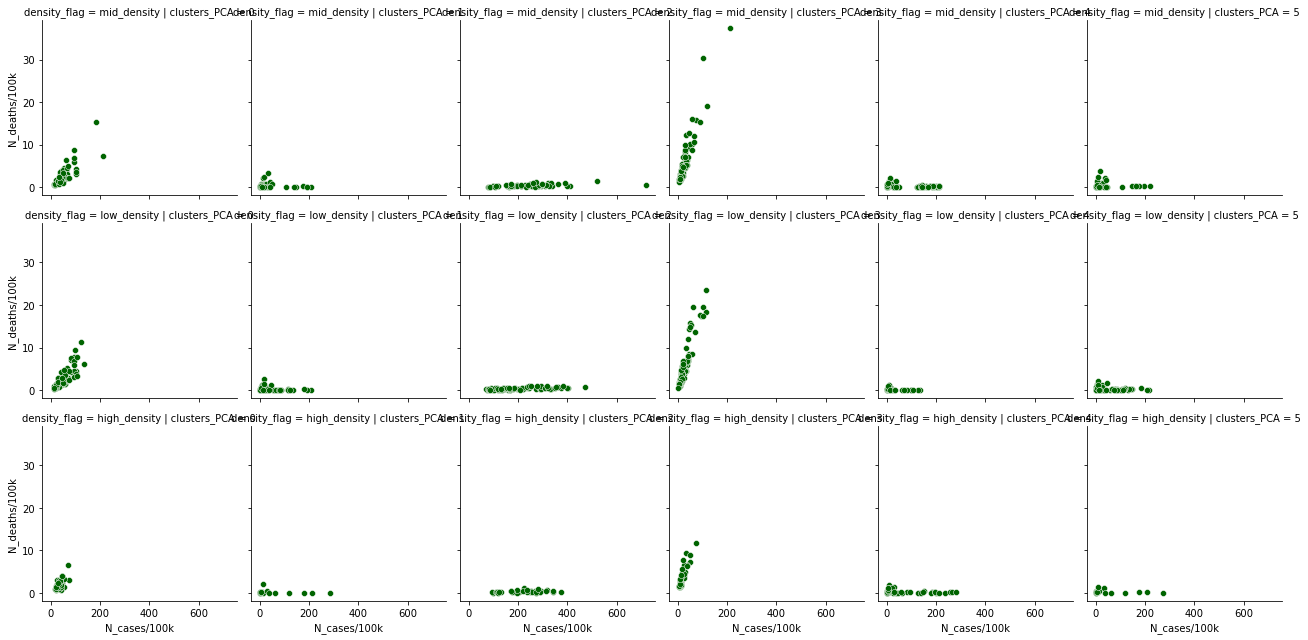

In [51]:
e=sns.FacetGrid(df_clean_pv, col='clusters_PCA')
e.map(sns.scatterplot, 'N_cases/100k', 'N_deaths/100k', color='black')

f=sns.FacetGrid(df_clean_pv, col='clusters_PCA', row='Gender')
f.map(sns.scatterplot, 'N_cases/100k', 'N_deaths/100k', color='r')

g = sns.FacetGrid(df_clean_pv, col='clusters_PCA',  row="Age_group")
g.map(sns.scatterplot, "N_cases/100k", "N_deaths/100k",color='b')

h=sns.FacetGrid(df_clean_pv, col='clusters_PCA', row='climate_flag')
h.map(sns.scatterplot, 'N_cases/100k', 'N_deaths/100k', color='darkorange')

i = sns.FacetGrid(df_clean_pv, col='clusters_PCA',  row="season")
i.map(sns.scatterplot, "N_cases/100k", "N_deaths/100k",color='brown')

j = sns.FacetGrid(df_clean_pv, col='clusters_PCA',  row="density_flag")
j.map(sns.scatterplot, "N_cases/100k", "N_deaths/100k",color='darkgreen')


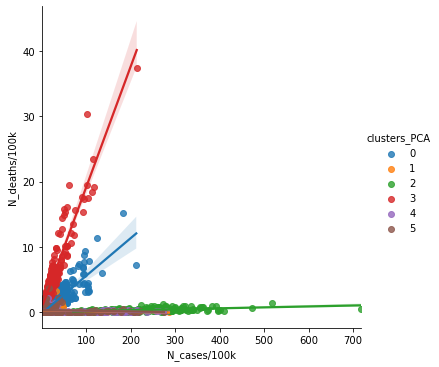

In [52]:
sns.lmplot(data=df_clean_pv, x='N_cases/100k', y='N_deaths/100k', hue='clusters_PCA')

### 4 Clusters Description
#### - CLUSTER 0: 
    No distinction in gender, aged between 60 and 79 years, mostly from States with Continantal climate, relative only to cold months
#### - CLUSTER 1: 
    Female, mostly under 60 years of age, from a State with Continental climate, relative only to warm months. 
#### - CLUSTER 2:
    No distinction in gender, under 60 years of age, relative only to cold months.
#### - CLUSTER 3: 
    No distinction in gender, aged 80 or more,  mostly from states with Continental climate,relative to cold months only.
#### - CLUSTER 4:
    Mostly people under 60 years old, no distinction in gender, from states with an Oceanic climate, relative to warm months only.
#### - CLUSTER 5:
    Male, mostly under 60 years of age, relative only to warm months.





### 5 NEXT STEPS

The cluster analysis revealed the presence of 6 clusters. Each cluster represent a subgroup of the population an period of the year. While some clusters contains mixed population/geographical characteristics, all of them are relative to only one of the two climatic seasons of the year (either cold or warm).

__NEXT STEPS OF THE ANALYSIS:__

I will focus on time-series analysis, performing separate analyses on Continental-climate and Oceanic climate States.
The data can be also split by age group, as there are great difference in behavior among differences in age, and time-series analysis performedon each subset.
The objective is to refine the time-series analysis and forcasting for each of the principal population subsets.

In [46]:
df_clean_pv.head()

,State,Gender,Age_group,climate_flag,density_flag,season,month,N_cases/100k,N_deaths/100k,clusters_PCA
0,Baden-Württemberg,F,60-79,oceanic,mid_density,cold,1,35.566826,1.224889,0
1,Baden-Württemberg,F,60-79,oceanic,mid_density,cold,2,15.347144,0.468340,0
2,Baden-Württemberg,F,60-79,oceanic,mid_density,cold,3,45.708190,1.414027,0
3,Baden-Württemberg,F,60-79,oceanic,mid_density,cold,4,53.850102,1.648197,0
4,Baden-Württemberg,F,60-79,oceanic,mid_density,cold,11,43.186359,1.305948,0


In [47]:
df_clean_pv.to_csv(os.path.join(path,'data','prepared_data','df_clusters.csv'))